## Colab Initialization

In [ ]:
!unzip uncond_ts_diff.zip
!pip install "gluonts[mxnet,pro]~=0.12.3"
!pip install "pytorch-lightning~=1.9.4"

In [ ]:
!zip -r lightning_logs.zip lightning_logs

In [78]:
!zip -r images.zip images
!zip -r models.zip models

  adding: images/ (stored 0%)
  adding: images/AMZN_tsdiff_Mean.png (deflated 7%)
  adding: images/.ipynb_checkpoints/ (stored 0%)
  adding: images/AAPL_tsdiff_Mean.png (deflated 8%)
  adding: images/GOOGL_tsdiff_Mean.png (deflated 7%)
  adding: images/AMZN_tsdiff_Median.png (deflated 7%)
  adding: images/^GSPC_tsdiff_Mean.png (deflated 7%)
  adding: images/^GSPC_tsdiff_Median.png (deflated 7%)
  adding: images/TSLA_tsdiff_Median.png (deflated 7%)
  adding: images/AAPL_tsdiff_Median.png (deflated 8%)
  adding: images/TSLA_tsdiff_Mean.png (deflated 7%)
  adding: images/GOOGL_tsdiff_Median.png (deflated 7%)
  adding: models/ (stored 0%)
  adding: models/GOOGL.model (deflated 9%)
  adding: models/^GSPC.model (deflated 9%)
  adding: models/AAPL.model (deflated 9%)
  adding: models/TSLA.model (deflated 9%)
  adding: models/AMZN.model (deflated 9%)


In [ ]:
!rm -r lightning_logs

## Init Parameters

In [67]:
import torch

ticker = "^GSPC"
freq = "1d"
target_col = "Adj Close",
start_date = "2000-01-01"
end_date = "2024-11-30"

diffusion_config = "diffusion_small_config"
normalization = "mean"
gradient_clip_val = 0.5
sampler_method = "ddpm"
sampler_params = {"guidance": "quantile", "scale": 2}

lr = 1.e-3
# train_ratio = 0.8
test_period = 30
batch_size = 64
max_epochs = 200
num_batches_per_epoch = 128

context_length = 30
prediction_length = 1
total_length = context_length + prediction_length

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
out_dir = "./"

## Create Dataset

In [68]:
import yfinance as yf
from gluonts.dataset.common import ListDataset

def get_dataset():
    data = yf.download(ticker, start=start_date, end=end_date)[target_col][ticker]
    # train_size = int(len(data) * train_ratio)

    train_data = data[:-test_period]
    test_data = data#[-test_period:]

    train_dataset = ListDataset(
        [{"start": train_data.index[0], "target": train_data.values}],
        freq=freq[-1]
    )
    # test_dataset = ListDataset(
    #     [{"start": test_data.index[0], "target": test_data.values}],
    #     freq=freq[-1]
    # )
    test_dataset = ListDataset(
        [{"start": data.index[0], "target": data.values}],
        freq=freq[-1]
    )
    return train_data, train_dataset, test_data, test_dataset

train_data, train_dataset, test_data, test_dataset = get_dataset()


[*********************100%***********************]  1 of 1 completed


## Create Model

In [69]:
import uncond_ts_diff.configs as diffusion_configs
from uncond_ts_diff.model import TSDiff

def create_model():
    model = TSDiff(
        **getattr(diffusion_configs, diffusion_config),
        freq=freq[-1],
        use_features=False,
        use_lags=True,
        normalization=normalization,
        context_length=context_length,
        prediction_length=prediction_length,
        lr=lr,
        init_skip=False,
    )
    model.to(device)
    return model

model = create_model()

## Evaluate Guidance

In [70]:
from tqdm.auto import tqdm

from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import make_evaluation_predictions, Evaluator

from uncond_ts_diff.sampler import DDPMGuidance, DDIMGuidance
from uncond_ts_diff.utils import create_splitter, MaskInput, filter_metrics, create_transforms


guidance_map = {"ddpm": DDPMGuidance, "ddim": DDIMGuidance}


def evaluate_guidance(
    model, test_dataset, transformation, num_samples=100
):

    print(f"Evaluating with {num_samples} samples.")

    missing_data_kwargs = {
        "missing_scenario": "none",
        "missing_values": 0,
    }


    Guidance = guidance_map[sampler_method]

    print(
        f"Evaluating scenario '{missing_data_kwargs['missing_scenario']}' "
        f"with {missing_data_kwargs['missing_values']:.1f} missing_values."
    )
    sampler = Guidance(
        model=model,
        prediction_length=prediction_length,
        num_samples=num_samples,
        **missing_data_kwargs,
        **sampler_params,
    )

    transformed_testdata = transformation.apply(
        test_dataset, is_train=False
    )
    test_splitter = create_splitter(
        past_length=context_length + max(model.lags_seq),
        future_length=prediction_length,
        mode="test",
    )

    masking_transform = MaskInput(
        FieldName.TARGET,
        FieldName.OBSERVED_VALUES,
        context_length,
        missing_data_kwargs["missing_scenario"],
        missing_data_kwargs["missing_values"],
    )
    test_transform = test_splitter + masking_transform

    predictor = sampler.get_predictor(
        test_transform,
        batch_size=1280 // num_samples,
        device=device,
    )
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=transformed_testdata,
        predictor=predictor,
        num_samples=num_samples,
    )
    forecasts = list(tqdm(forecast_it, total=len(transformed_testdata)))
    tss = list(ts_it)
    evaluator = Evaluator()
    metrics, _ = evaluator(tss, forecasts)
    # metrics = filter_metrics(metrics)
    return {"metrics": {**metrics}, "forecast": forecasts, "tss": tss}

transformation = create_transforms(
  num_feat_dynamic_real=0,
  num_feat_static_cat=0,
  num_feat_static_real=0,
  time_features=model.time_features,
  prediction_length=prediction_length,
)

## Training

In [71]:
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
from gluonts.dataset.loader import TrainDataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
from pathlib import Path

from uncond_ts_diff.utils import create_splitter



training_splitter = create_splitter(
    past_length=context_length + max(model.lags_seq),
    future_length=prediction_length,
    mode="train",
)

callbacks = []
transformed_data = transformation.apply(train_dataset, is_train=True)

log_monitor = "train_loss"
filename = ticker + "-{epoch:03d}-{train_loss:.3f}"

data_loader = TrainDataLoader(
    Cached(transformed_data),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor=f"{log_monitor}",
    mode="min",
    filename=filename,
    save_last=True,
    save_weights_only=True,
)

callbacks.append(checkpoint_callback)
callbacks.append(RichProgressBar())

trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else None,
    # devices=[int(config["device"].split(":")[-1])],
    max_epochs=max_epochs,
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    callbacks=callbacks,
    default_root_dir=out_dir,
    gradient_clip_val=gradient_clip_val,
)
print(f"Logging to {trainer.logger.log_dir}")
trainer.fit(model, train_dataloaders=data_loader)
print("Training completed.")

torch.save(
    torch.load(checkpoint_callback.best_model_path)["state_dict"],
    f"models/{ticker}.model",
)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Logging to ./lightning_logs/version_4


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ scaler   │ MeanScaler      │      0 │
│ 1 │ embedder │ FeatureEmbedder │      1 │
│ 2 │ backbone │ BackboneModel   │  193 K │
└───┴──────────┴─────────────────┴────────┘

Trainable params: 193 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 193 K                                                                                                
Total estimated model params size (MB): 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Training completed.


<ipython-input-71-de4c7262ec1e>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(checkpoint_callback.best_model_path)["state_dict"],


## Evaluation

In [73]:
model_path = f"models/{ticker}.model"
print(f"Loading {model_path}.")
best_state_dict = torch.load(model_path)
model.load_state_dict(best_state_dict, strict=True)

result_mean = []
result_median = []
lower_bound = []
upper_bound = []
for i in tqdm(range(test_period)):
  test_dataset = ListDataset(
        [{"start": test_data.index[0], "target": test_data[:-test_period+i].values}],
        freq=freq[-1]
    )
  res = evaluate_guidance(model, test_dataset, transformation)
  result_mean.append(res["forecast"][0].mean[0])
  result_median.append(res["forecast"][0].quantile(0.5)[0])
  lower_bound.append(res["forecast"][0].quantile(0.05)[0])
  upper_bound.append(res["forecast"][0].quantile(0.95)[0])

Loading models/^GSPC.model.


<ipython-input-73-df88324c01c6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load(model_path)


  0%|          | 0/30 [00:00<?, ?it/s]

Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 25.62it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 40.28it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 39.12it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 46.23it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 47.59it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 43.21it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 42.27it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 41.70it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 32.25it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 44.86it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 40.26it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 40.65it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 42.19it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 51.79it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 44.57it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 39.02it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 38.06it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 38.31it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 32.63it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 46.15it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 30.32it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 44.73it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 43.69it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 96.68it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 35.86it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 85.05it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 34.48it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 137.18it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 37.91it/s]


Evaluating with 100 samples.
Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/1 [00:00<?, ?it/s]


Running evaluation: 1it [00:00, 106.71it/s]


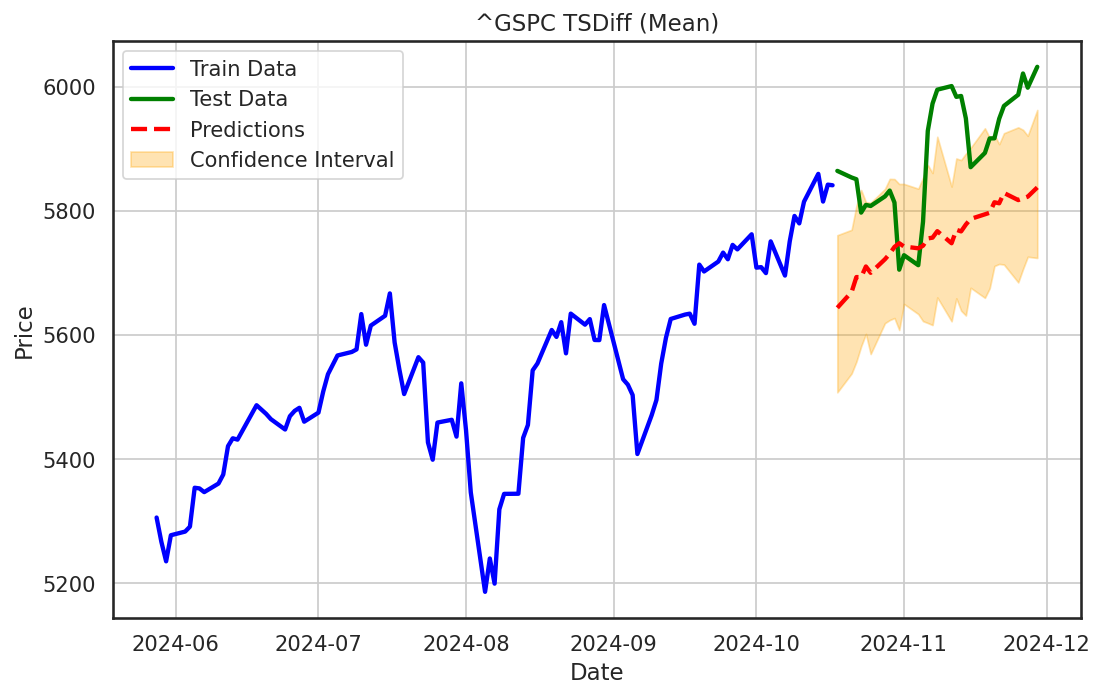

In [74]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(train_data.index[-100:], train_data[-100:], label='Train Data', color='blue')
plt.plot(test_data.index[-30:], test_data[-30:], label='Test Data', color='green')
plt.plot(test_data.index[-30:], result_mean, label='Predictions', color='red', linestyle='--')
plt.fill_between(test_data.index[-30:], lower_bound, upper_bound, alpha=0.3, color='orange', label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f"{ticker} TSDiff (Mean)")
plt.legend()
plt.grid(True)
plt.savefig(f'images/{ticker}_tsdiff_Mean.png')
plt.show()


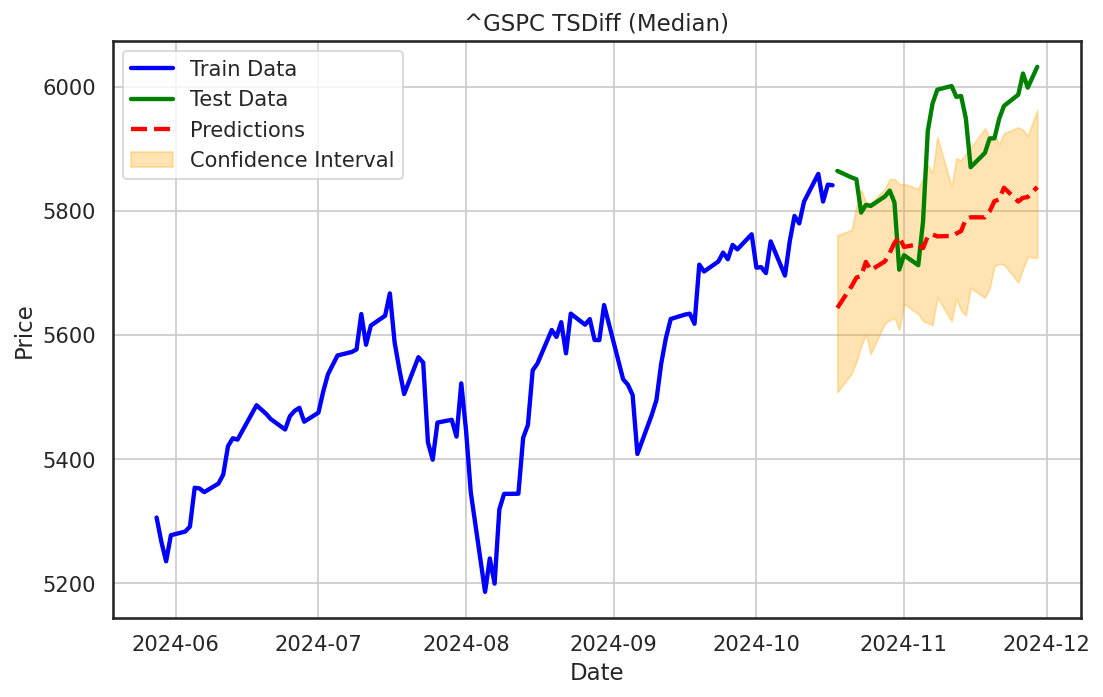

In [75]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(train_data.index[-100:], train_data[-100:], label='Train Data', color='blue')
plt.plot(test_data.index[-30:], test_data[-30:], label='Test Data', color='green')
plt.plot(test_data.index[-30:], result_median, label='Predictions', color='red', linestyle='--')
plt.fill_between(test_data.index[-30:], lower_bound, upper_bound, alpha=0.3, color='orange', label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f"{ticker} TSDiff (Median)")
plt.legend()
plt.grid(True)
plt.savefig(f'images/{ticker}_tsdiff_Median.png')
plt.show()


In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

actual = np.array(test_data[-test_period:].values)
# predicted = np.array(result_mean)
predicted = np.array(result_median)

mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predicted)

print(ticker)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

^GSPC
Mean Absolute Error (MAE): 137.70
Mean Squared Error (MSE): 22966.69
Root Mean Squared Error (RMSE): 151.55
R² Score: -1.60


# Dummy

In [ ]:
forecast_entry = result["forecast"][0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")


Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2024-10-24
Frequency of the time series: <Day>


In [ ]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")


Mean of the future window:
 [318.77905 319.11963 319.31308 319.81073 320.6274  321.46872 322.9391
 324.40506 324.59155 325.81412 326.0501  328.16714 328.17426 329.44016
 329.87802 330.4937  329.84726 328.80255 328.1218  327.84882 325.513
 325.1687  325.6051  327.44318]
0.5-quantile (median) of the future window:
 [309.62213 309.11716 310.08597 309.03644 314.24722 315.54706 316.53012
 320.98712 318.66827 322.5311  327.09604 327.62476 326.8856  324.9469
 326.16382 333.06003 330.99222 325.2404  325.1538  323.90335 324.0642
 323.48676 320.8642  328.8618 ]


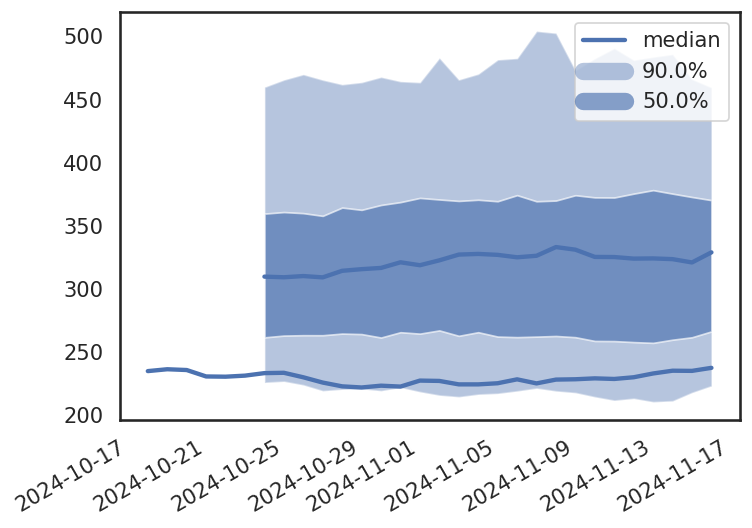

In [ ]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot()
plt.legend()